# Economic Indicators

Let's investigate how some economic indicators are related to crime activity in a region.

## Environment Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set(style='whitegrid', rc={'axes.grid' : False})

In [3]:
# load crime data
crimes_df = pd.read_pickle('data/processed_data.pkl')

## **2015**

In [4]:
eco_2015 = pd.read_csv('data/external/Economic_Indicators_2015.csv', index_col='Community Area')
eco_2015.head()

,Community Area Name,Below Poverty Level,Per Capita Income,Unemployment
Community Area,,,,
1,Rogers Park,22.7,23714,7.5
2,West Ridge,15.1,21375,7.9
3,Uptown,22.7,32355,7.7
4,Lincoln Square,9.5,35503,6.8
5,North Center,7.1,51615,4.5


## House Prices

Let's add House Price data to our investigation.

In [5]:
house_prices = pd.read_csv('data/external/house_prices_per_community.csv', index_col='Month', parse_dates=True)
house_prices_2015 = house_prices['2015']

In [6]:
house_prices_2015.groupby('Community Area').mean()

,Avg Price
Community Area,
1.0,143200.000000
2.0,214954.166667
3.0,225925.000000
4.0,349277.777778
5.0,436229.166667
6.0,340175.000000
7.0,446180.000000
8.0,311938.095238
9.0,315458.333333


In [7]:
eco_2015 = eco_2015.join(house_prices_2015.groupby('Community Area').mean(),
                         on='Community Area')
eco_2015.rename(columns={'Avg Price': 'House Avg Price'}, inplace=True)

In [8]:
crimes_2015 = crimes_df['2015']

In [9]:
crimes_2015.columns

Index(['ID', 'Case Number', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community Area', 'FBI Code', 'Year', 'Updated On', 'Latitude',
       'Longitude'],
      dtype='object')

In [10]:
eco_indicators = ['Below Poverty Level', 'Per Capita Income', 'Unemployment', 'House Avg Price']

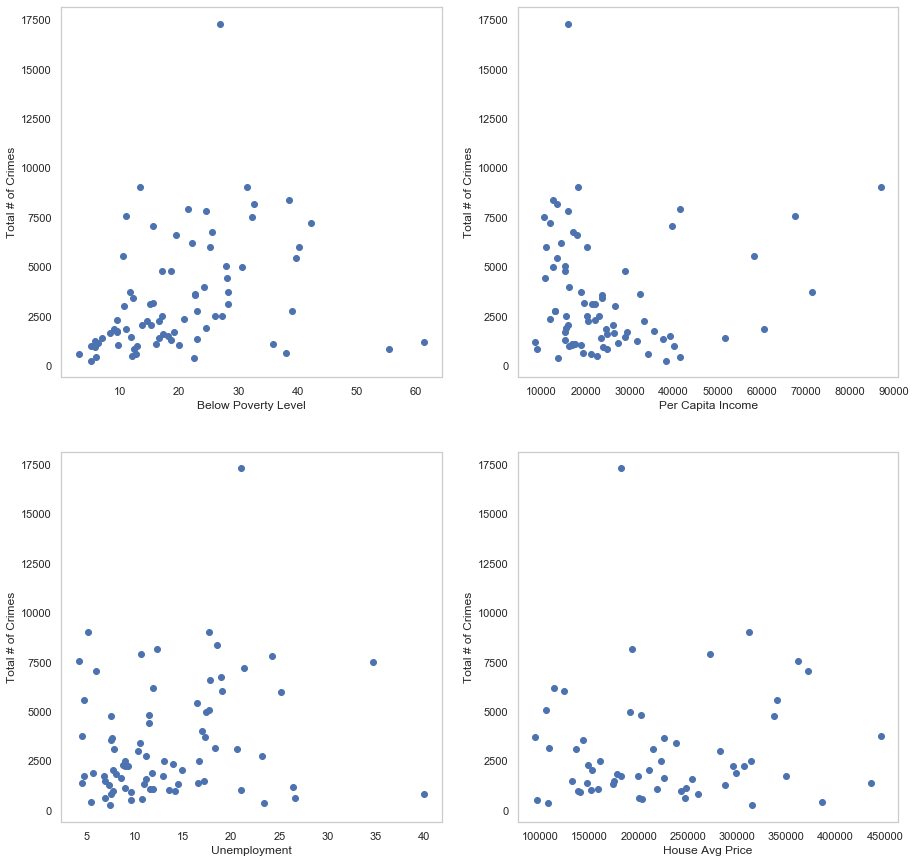

In [12]:
# total number of crimes per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))
for i, indicator in enumerate(eco_indicators):
    ax_ix = (i//2, i%2)
    ax[ax_ix].scatter(x=eco_2015[indicator],
                      y=crimes_2015.groupby('Community Area').size())
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('Total # of Crimes')

Let's compute **crimes per capita** per region.

**Note:** using most recent population estimates, from the 2010 census.

In [13]:
pop_comm = pd.read_pickle('data/external/Population_by_Community_Area.pkl')

In [14]:
eco_2015 = eco_2015.join(pop_comm)
eco_2015.rename(columns = {'2010': '2010 Population',
                           '2000': '2000 Population'},
               inplace=True)

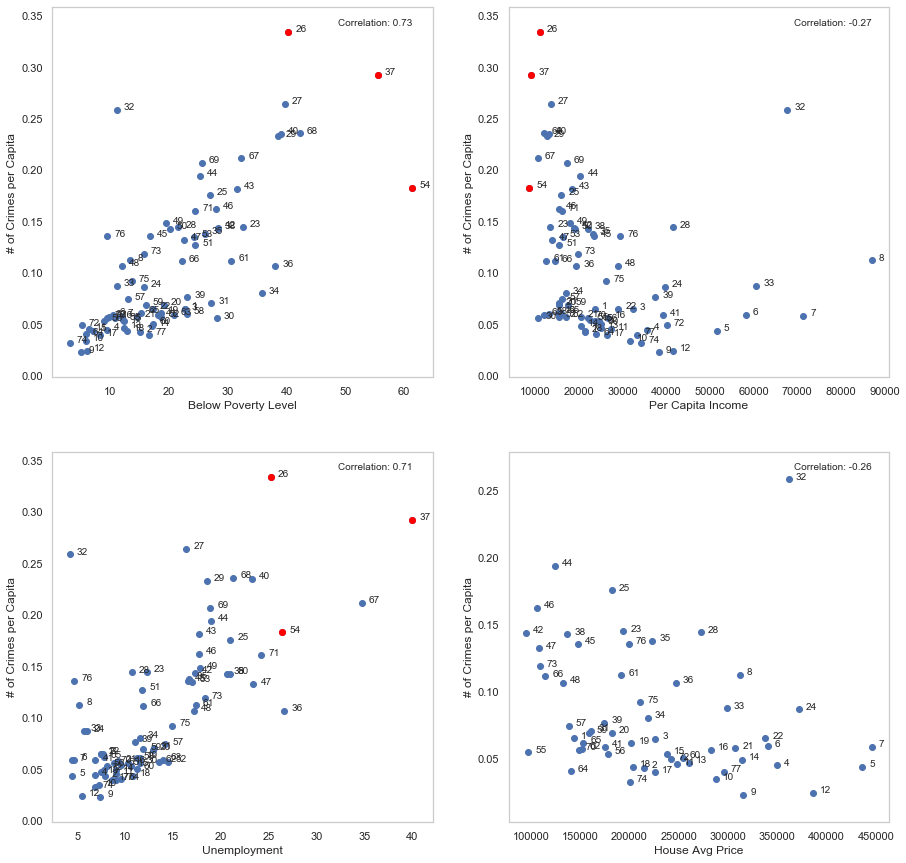

In [23]:
# crimes per capita per region
fig, ax = plt.subplots(2, 2, figsize=(15,15))

crimes_per_capita = crimes_2015.groupby('Community Area').size()/eco_2015['2010 Population']
crimes_per_capita.rename('Crimes per Capita', inplace=True)

for i, indicator in enumerate(eco_indicators):    
    ax_ix = (i//2, i%2)
    x, y = eco_2015[indicator], crimes_per_capita
    ax[ax_ix].scatter(x, y)
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('# of Crimes per Capita')
    # let's also check the numeric correlation
    ax[ax_ix].annotate('Correlation: {}'.format(crimes_per_capita.corr(eco_2015[indicator]).round(decimals=2)),
                       xy=(.75, .95),
                       xycoords='axes fraction')
    # add annotation of Community Area ID
    for i, s in pd.concat([x,y], axis=1).iterrows():
        text = int(i)
        ax[ax_ix].annotate(text,
                           xy = (s[indicator], s['Crimes per Capita']),
                           xytext = (7, 0),
                           textcoords = 'offset points')
        # highlight specified communities
        comm = [37,26,54]
        if int(i) in comm:
            ax[ax_ix].scatter(s[indicator], s['Crimes per Capita'], color='red')

### What's up with Community 32?

From the plots above, it looks like community 32 is a well-off community, but the number of crimes committed in it is quite large. Let's investigate it further.

In [24]:
# what community is it?
eco_2015.loc[32, 'Community Area Name']

'Loop'

From [Wikipedia](https://en.wikipedia.org/wiki/Chicago_Loop):

> The Loop, one of Chicago's 77 designated community areas, is the central business district in the downtown area of the city. It is home to Chicago's commercial core, City Hall, and the seat of Cook County. 

## **2008–2012**

Now let's investigate the years with data from 2008–2012.

In [25]:
eco_2008 = pd.read_pickle('data/external/Economic_Indicators_2012.pkl')
eco_2008.head()

,Community Area Name,Below Poverty Level,Per Capita Income,Unemployment
Community Area,,,,
1,Rogers Park,23.6,23939,8.7
2,West Ridge,17.2,23040,8.8
3,Uptown,24.0,35787,8.9
4,Lincoln Square,10.9,37524,8.2
5,North Center,7.5,57123,5.2


In [26]:
crimes_2008_2012 = crimes_df['2008':'2012']

In [27]:
crimes_2008_2012.columns

Index(['ID', 'Case Number', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community Area', 'FBI Code', 'Year', 'Updated On', 'Latitude',
       'Longitude'],
      dtype='object')

In [28]:
eco_indicators_2008 = ['Below Poverty Level', 'Per Capita Income', 'Unemployment']

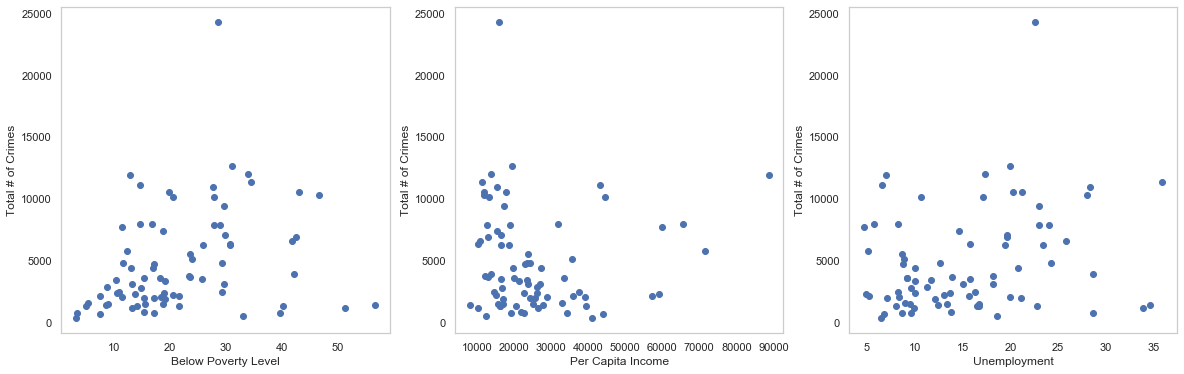

In [32]:
# total number of crimes per region
fig, ax = plt.subplots(1, 3, figsize=(20,6))

avg_crimes_2008_2012 = crimes_2008_2012.groupby(['Community Area', crimes_2008_2012.index.year]).size().groupby('Community Area').mean()

for i, indicator in enumerate(eco_indicators_2008):
#     ax_ix = (i//2, i%2)
    ax[i].scatter(x=eco_2008[indicator],
                  y=avg_crimes_2008_2012)
    ax[i].set_xlabel(indicator)
    ax[i].set_ylabel('Total # of Crimes')

Let's compute **crimes per capita** per region.

**Note:** using population estimates from the 2010 census.

In [33]:
eco_2008 = eco_2008.join(pop_comm)
eco_2008.rename(columns = {'2010': '2010 Population',
                           '2000': '2000 Population'},
               inplace=True)

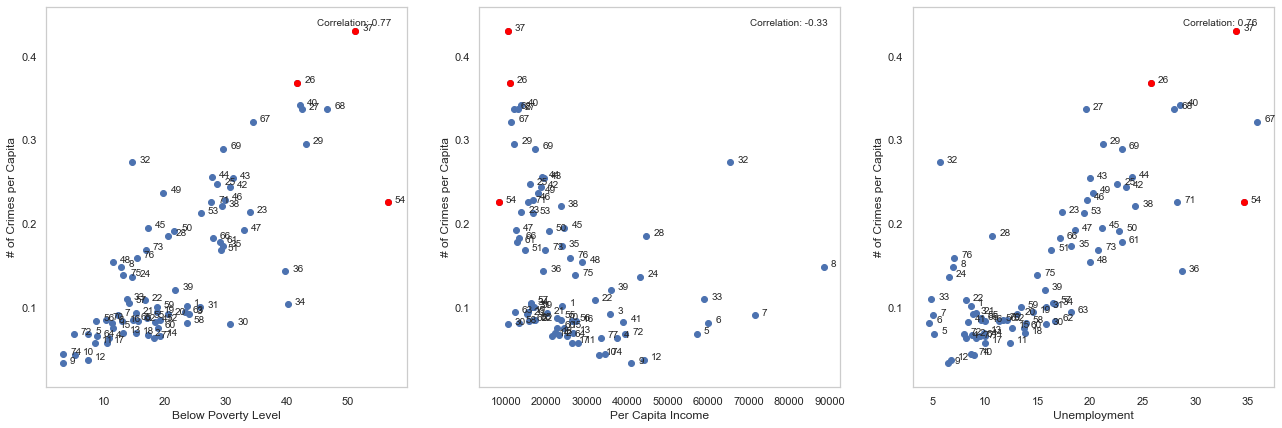

In [35]:
# crimes per capita per region
fig, ax = plt.subplots(1, 3, figsize=(22,7))

crimes_per_capita = avg_crimes_2008_2012/eco_2008['2010 Population']
crimes_per_capita.rename('Crimes per Capita', inplace=True)

for i, indicator in enumerate(eco_indicators_2008):    
#     ax_ix = (i//2, i%2)
    ax_ix = i
    x, y = eco_2008[indicator], crimes_per_capita
    ax[ax_ix].scatter(x, y)
    ax[ax_ix].set_xlabel(indicator)
    ax[ax_ix].set_ylabel('# of Crimes per Capita')
    # let's also check the numeric correlation
    ax[ax_ix].annotate('Correlation: {}'.format(crimes_per_capita.corr(eco_2008[indicator]).round(decimals=2)),
                       xy=(.75, .95),
                       xycoords='axes fraction')
    # add annotation of Community Area ID
    for i, s in pd.concat([x,y], axis=1).iterrows():
        text = int(i)
        ax[ax_ix].annotate(text,
                           xy = (s[indicator], s['Crimes per Capita']),
                           xytext = (7, 0),
                           textcoords = 'offset points')
        # highlight specified communities
        comm = [37,26,54]
        if int(i) in comm:
            ax[ax_ix].scatter(s[indicator], s['Crimes per Capita'], color='red')

### ———————————————————————————————————————

### Save/load data for work in progress

In [37]:
# Save data on disk to resume work later
crimes_df.to_pickle('data/processed_data.pkl')

In [123]:
crimes_df.to_csv('data/processed_data.csv')

In [3]:
crimes_df = pd.read_pickle('data/processed_data.pkl')

### ———————————————————————————————————————